## Step 4:  Fit the SPDE Spatial Model to the data

This notebook:
1. Compiles the SPDE Stan model (`spde_pm25.stan`)
2. Loads the preprocessed data from `json_data/stan_data.json`
3. Runs MCMC sampling
4. Provides basic diagnostics and visualization

**Prerequisites**: Run the FEM preprocessing notebook first to generate `json_data/stan_data.json`

### Setup and Imports

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CmdStanPy for Stan interface
from cmdstanpy import CmdStanModel, from_csv

### Load Preprocessed Data

In [2]:
# Load the preprocessed data
data_path = Path("json_data/stan_data.json")

if not data_path.exists():
    raise FileNotFoundError(
        f"Data file not found at {data_path}. "
        "Please run the FEM preprocessing notebook first."
    )

with open(data_path, 'r') as f:
    stan_data = json.load(f)

print(f"Loaded Stan data with {len(stan_data)} fields")
print(f"\nData dimensions:")
print(f"  Observations: {stan_data['N_obs']}")
print(f"  Mesh vertices: {stan_data['N_vertices']}")
print(f"  A matrix non-zeros: {stan_data['A_nnz']}")
print(f"  Q matrix non-zeros: {stan_data['Q_nnz']}")
print(f"\nPrior mean PM2.5: {stan_data['prior_mean']:.1f}")

Loaded Stan data with 19 fields

Data dimensions:
  Observations: 1339
  Mesh vertices: 3579
  A matrix non-zeros: 4013
  Q matrix non-zeros: 24927

Prior mean PM2.5: 7.8


### Fit the baseline model (no SPDE component)

In [4]:
# Compile the Stan model
model_path =  os.path.join('..', 'stan', 'base_model.stan')

if not Path(model_path).exists():
    raise FileNotFoundError(f"Stan model not found at {model_path}")

print("Compiling Stan model...")
base_model = CmdStanModel(stan_file=model_path)
print("Model compiled successfully!")

print("\nModel (data block):")
print("="*60)
with open(model_path, 'r') as f:
    lines = f.readlines()[:7]
    print(''.join(lines))
print("...")

11:54:29 - cmdstanpy - INFO - compiling stan file /Users/mitzi/github/zmorris/geo_spde/stan/base_model.stan to exe file /Users/mitzi/github/zmorris/geo_spde/stan/base_model


Compiling Stan model...


11:54:36 - cmdstanpy - INFO - compiled model executable: /Users/mitzi/github/zmorris/geo_spde/stan/base_model


Model compiled successfully!

Model (data block):
data {
  int<lower=1> N_obs;
  int<lower=1> N_countries;
  vector[N_obs] y;
  array[N_obs] int<lower=1,upper=N_countries> country;
  array[N_obs] int<lower=0,upper=1> is_urban;
}

...


### Configure Sampling Parameters

In [5]:
# Sampling configuration
sampling_config = {
    'refresh': 10,  # Print progress every X iterations
    'adapt_init_phase': 50,
    'adapt_metric_window': 25,
    'save_warmup' : True,
    'output_dir' : 'tmp',
}

### Run MCMC Sampling

**Note**: This may take several minutes depending on your data size and computer.

In [6]:
# Run the sampler
print("Starting MCMC sampling...")
print("This may take several minutes.\n")

base_fit = base_model.sample(
    data=stan_data,
    **sampling_config
)

print("\nSampling completed successfully!")

Starting MCMC sampling...
This may take several minutes.



11:54:49 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

11:54:54 - cmdstanpy - INFO - CmdStan done processing.
11:54:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base_model.stan', line 21, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!




Sampling completed successfully!


In [7]:
base_summary = base_fit.summary()
base_summary.head(7).round(2)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-1800.16,0.04,1.69,1.55,-1803.33,-1799.85,-1798.06,1527.51,2341.57,142.86,1.0
alpha,10.58,0.04,1.39,1.44,8.28,10.58,12.84,996.86,1248.89,93.23,1.0
beta_urban,0.05,0.05,2.47,2.41,-4.07,0.09,4.13,2291.80,1863.35,214.35,1.0
beta_country[1],-4.24,0.04,1.39,1.43,-6.54,-4.25,-1.93,1006.83,1224.00,94.17,1.0
beta_country[2],10.12,0.04,1.40,1.43,7.80,10.12,12.44,997.55,1315.44,93.30,1.0
beta_country[3],-3.22,0.04,1.39,1.44,-5.47,-3.22,-0.94,1004.90,1298.28,93.99,1.0
sigma,2.30,0.00,0.04,0.05,2.23,2.30,2.38,2331.31,2032.06,218.04,1.0


### Visualize Parameter Distributions

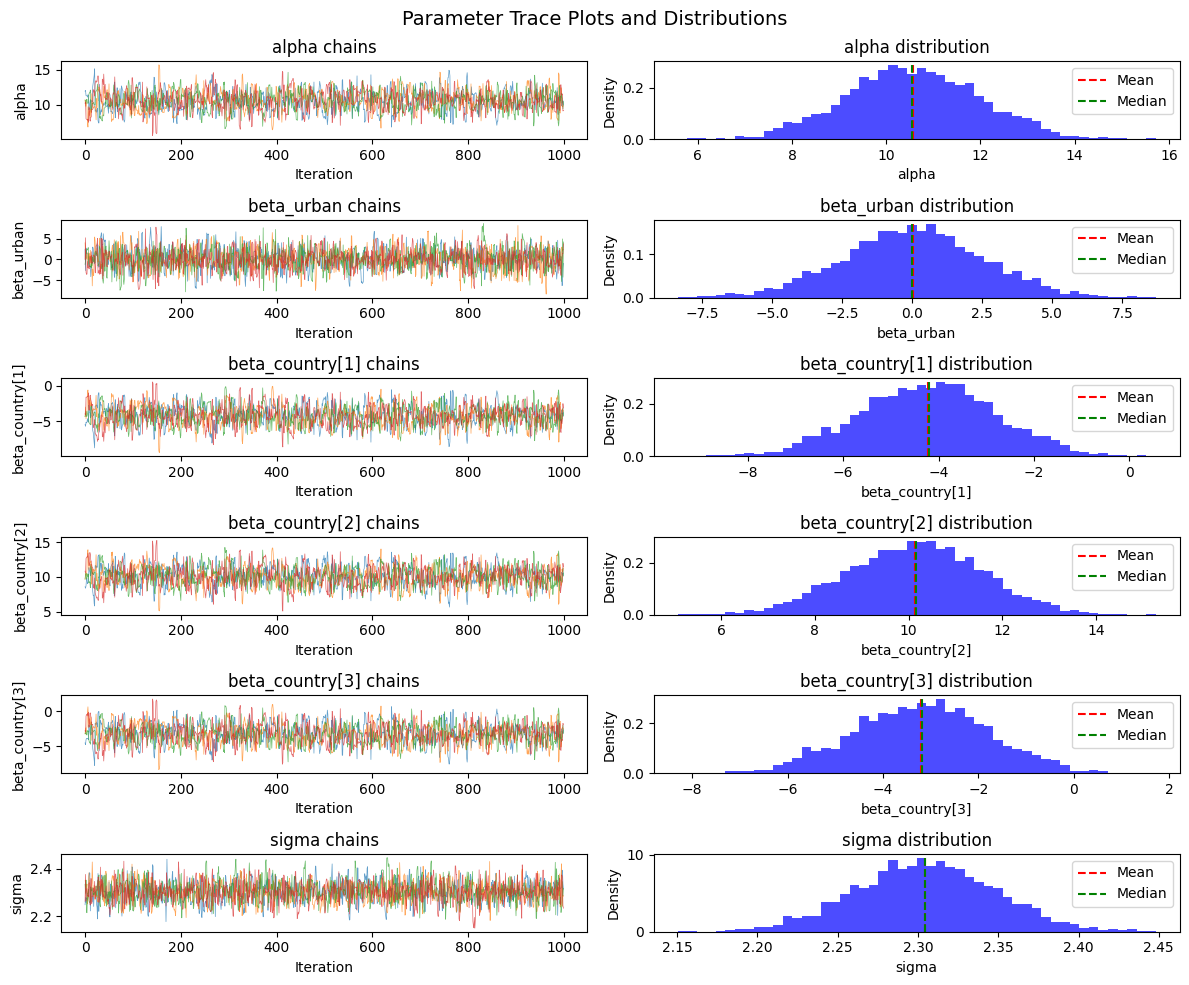

In [8]:
# Extract samples for main parameters
draws = base_fit.draws_pd()
main_params=['alpha', 'beta_urban', 'beta_country[1]', 'beta_country[2]', 'beta_country[3]', 'sigma']
# Create trace plots
fig, axes = plt.subplots(len(main_params), 2, figsize=(12, 10))
fig.suptitle('Parameter Trace Plots and Distributions', fontsize=14)

for idx, param in enumerate(main_params):
    # Trace plot
    ax_trace = axes[idx, 0]
    for chain in range(4):
        chain_draws = draws[draws['chain__'] == chain+1][param]
        ax_trace.plot(chain_draws.values, alpha=0.7, linewidth=0.5)
    ax_trace.set_ylabel(param)
    ax_trace.set_xlabel('Iteration')
    ax_trace.set_title(f'{param} chains')
    
    # Histogram
    ax_hist = axes[idx, 1]
    ax_hist.hist(draws[param], bins=50, density=True, alpha=0.7, color='blue')
    ax_hist.axvline(draws[param].mean(), color='red', linestyle='--', label='Mean')
    ax_hist.axvline(draws[param].median(), color='green', linestyle='--', label='Median')
    ax_hist.set_xlabel(param)
    ax_hist.set_ylabel('Density')
    ax_hist.set_title(f'{param} distribution')
    ax_hist.legend()

plt.tight_layout()
plt.show()

### Add an SPDE component

### Spatial smoothing

In [13]:
spde_path =  os.path.join('..', 'stan', 'spde_spatial_only.stan')
spde_model = CmdStanModel(stan_file=spde_path)

12:17:45 - cmdstanpy - INFO - compiling stan file /Users/mitzi/github/zmorris/geo_spde/stan/spde_spatial_only.stan to exe file /Users/mitzi/github/zmorris/geo_spde/stan/spde_spatial_only
12:17:49 - cmdstanpy - INFO - compiled model executable: /Users/mitzi/github/zmorris/geo_spde/stan/spde_spatial_only


In [16]:
print("\nModel (data block):")
print("="*60)
with open(spde_path, 'r') as f:
    lines = f.readlines()[12:32]
    print(''.join(lines))
print("...")


Model (data block):
  int<lower=1> N_obs;                 // number of observations
  int<lower=1> N_mesh;                // number of mesh vertices
  
  // Sparse matrix A (projector) in CSR format
  int<lower=0> A_nnz;                 // number of non-zeros in A
  vector[A_nnz] A_w;                  // values
  array[A_nnz] int A_v;               // column indices (1-indexed)
  array[N_obs + 1] int A_u;           // row pointers (1-indexed)
  
  // Sparse matrix Q (precision) in CSR format  
  int<lower=0> Q_nnz;                 // number of non-zeros in Q
  vector[Q_nnz] Q_w;                  // values (for kappa=1, tau=1)
  array[Q_nnz] int Q_v;               // column indices (1-indexed)
  array[N_mesh + 1] int Q_u;          // row pointers (1-indexed)
  
  real log_det_Q_base;                // log determinant for base Q (kappa=1, tau=1)
  
  // Observations
  vector[N_obs] y;                    // observed values
}

...


In [17]:
stan_data.keys()

dict_keys(['N_obs', 'N_vertices', 'N_countries', 'y', 'is_urban', 'country', 'prior_mean', 'A_w', 'A_v', 'A_u', 'A_nnz', 'A_nrow', 'A_ncol', 'Q_w', 'Q_v', 'Q_u', 'Q_nnz', 'Q_nrow', 'Q_ncol'])

In [12]:
# Run the sampler
print("Starting MCMC sampling...")
print("This may take several minutes.\n")

spde_fit = spde_model.sample(
    data=stan_data,
    **sampling_config
)

print("\nSampling completed successfully!")

Starting MCMC sampling...
This may take several minutes.



22:40:55 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

22:46:00 - cmdstanpy - INFO - CmdStan done processing.




Sampling completed successfully!


In [18]:
spde_summary = spde_fit.summary()

In [30]:
spde_summary.loc[['alpha', 'beta_urban', 
                   'beta_country[1]', 'beta_country[2]', 'beta_country[3]', 
                   'sigma', 'tau']].round(2)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
alpha,10.90,0.05,1.35,1.31,8.70,10.90,13.22,703.27,1631.74,2.10,1.01
beta_urban,0.01,0.04,2.47,2.45,-4.11,0.01,4.08,3738.28,3098.21,11.16,1.00
beta_country[1],-4.37,0.05,1.35,1.32,-6.71,-4.35,-2.17,719.60,1633.51,2.15,1.01
beta_country[2],10.30,0.05,1.36,1.36,8.03,10.30,12.53,727.82,1575.98,2.17,1.01
beta_country[3],-3.20,0.05,1.34,1.30,-5.49,-3.19,-1.01,717.07,1644.81,2.14,1.01
sigma,2.08,0.00,0.05,0.05,2.00,2.08,2.16,2313.19,2931.99,6.90,1.00
tau,68.29,0.20,2.86,2.91,63.64,68.31,72.96,238.77,335.29,0.71,1.01


In [31]:
base_summary.head(7).round(2)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-1800.24,0.04,1.74,1.57,-1803.47,-1799.93,-1798.01,1618.69,2261.85,168.28,1.01
alpha,10.57,0.04,1.42,1.44,8.21,10.54,12.94,1096.86,1568.42,114.03,1.00
beta_country[1],-4.23,0.04,1.43,1.44,-6.62,-4.20,-1.84,1103.04,1496.76,114.67,1.00
beta_country[2],10.13,0.04,1.44,1.45,7.75,10.15,12.47,1098.04,1513.80,114.15,1.00
beta_country[3],-3.21,0.04,1.42,1.42,-5.58,-3.18,-0.85,1098.07,1542.74,114.16,1.00
beta_urban,0.02,0.06,2.54,2.45,-4.15,0.01,4.20,1996.28,1852.14,207.54,1.00
sigma,2.30,0.00,0.04,0.04,2.23,2.30,2.38,2057.86,1799.50,213.94,1.00


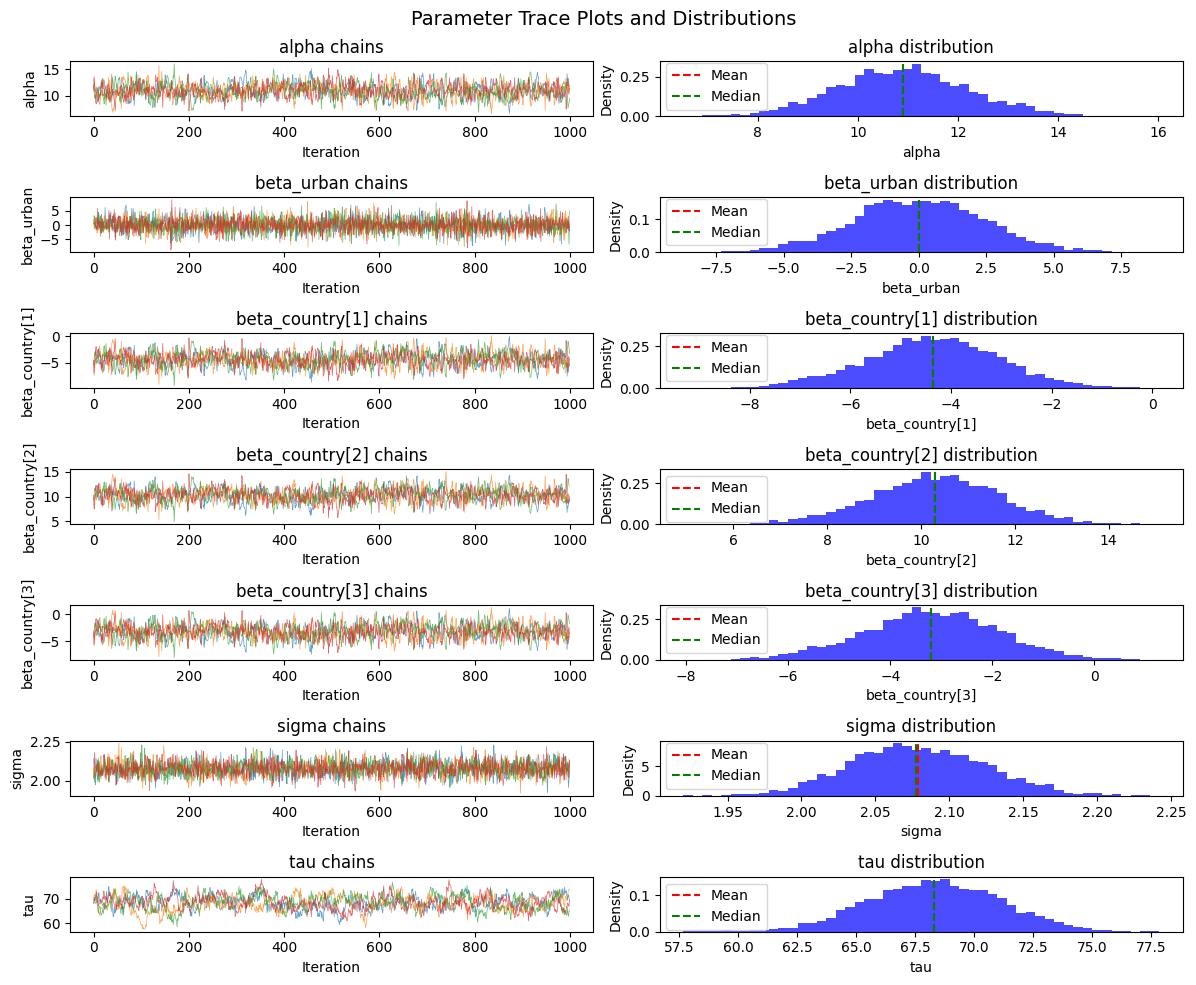

In [32]:
# Extract samples for main parameters
draws = spde_fit.draws_pd()
main_params=['alpha', 'beta_urban', 'beta_country[1]', 'beta_country[2]', 'beta_country[3]', 'sigma', 'tau']
# Create trace plots
fig, axes = plt.subplots(len(main_params), 2, figsize=(12, 10))
fig.suptitle('Parameter Trace Plots and Distributions', fontsize=14)

for idx, param in enumerate(main_params):
    # Trace plot
    ax_trace = axes[idx, 0]
    for chain in range(4):
        chain_draws = draws[draws['chain__'] == chain+1][param]
        ax_trace.plot(chain_draws.values, alpha=0.7, linewidth=0.5)
    ax_trace.set_ylabel(param)
    ax_trace.set_xlabel('Iteration')
    ax_trace.set_title(f'{param} chains')
    
    # Histogram
    ax_hist = axes[idx, 1]
    ax_hist.hist(draws[param], bins=50, density=True, alpha=0.7, color='blue')
    ax_hist.axvline(draws[param].mean(), color='red', linestyle='--', label='Mean')
    ax_hist.axvline(draws[param].median(), color='green', linestyle='--', label='Median')
    ax_hist.set_xlabel(param)
    ax_hist.set_ylabel('Density')
    ax_hist.set_title(f'{param} distribution')
    ax_hist.legend()

plt.tight_layout()
plt.show()

### Posterior Predictive Checks

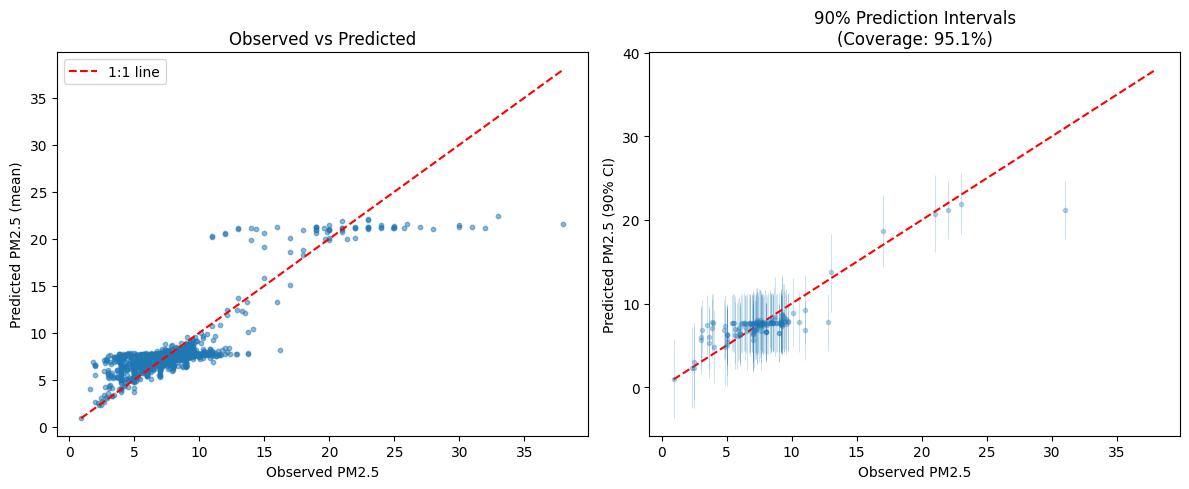

Residual statistics:
  Mean: 0.002
  Std: 1.830
  RMSE: 1.830
  MAE: 1.217


In [33]:
# Extract posterior predictive samples
y_rep_cols = [col for col in draws.columns if col.startswith('y_rep[')]
y_rep = draws[y_rep_cols].values

# Get observed data
y_obs = np.array(stan_data['y'])

# Calculate posterior predictive mean and intervals
y_rep_mean = y_rep.mean(axis=0)
y_rep_lower = np.percentile(y_rep, 5, axis=0)
y_rep_upper = np.percentile(y_rep, 95, axis=0)

# Plot observed vs predicted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Observed vs predicted means
ax1 = axes[0]
ax1.scatter(y_obs, y_rep_mean, alpha=0.5, s=10)
ax1.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'r--', label='1:1 line')
ax1.set_xlabel('Observed PM2.5')
ax1.set_ylabel('Predicted PM2.5 (mean)')
ax1.set_title('Observed vs Predicted')
ax1.legend()

# Coverage plot
ax2 = axes[1]
in_interval = (y_obs >= y_rep_lower) & (y_obs <= y_rep_upper)
coverage = in_interval.mean() * 100

ax2.errorbar(y_obs[::10], y_rep_mean[::10], 
             yerr=[y_rep_mean[::10] - y_rep_lower[::10], 
                   y_rep_upper[::10] - y_rep_mean[::10]],
             fmt='o', alpha=0.3, markersize=3, elinewidth=0.5)
ax2.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'r--')
ax2.set_xlabel('Observed PM2.5')
ax2.set_ylabel('Predicted PM2.5 (90% CI)')
ax2.set_title(f'90% Prediction Intervals\n(Coverage: {coverage:.1f}%)')

plt.tight_layout()
plt.show()

# Print summary statistics
residuals = y_obs - y_rep_mean
print(f"Residual statistics:")
print(f"  Mean: {residuals.mean():.3f}")
print(f"  Std: {residuals.std():.3f}")
print(f"  RMSE: {np.sqrt((residuals**2).mean()):.3f}")
print(f"  MAE: {np.abs(residuals).mean():.3f}")

### Extract and Visualize Spatial Field

The spatial field `w` at mesh vertices captures the spatial correlation structure.

Spatial field statistics:
  Number of vertices: 3579
  Mean value: -0.002
  Std of means: 0.003
  Range: [-0.014, 0.016]


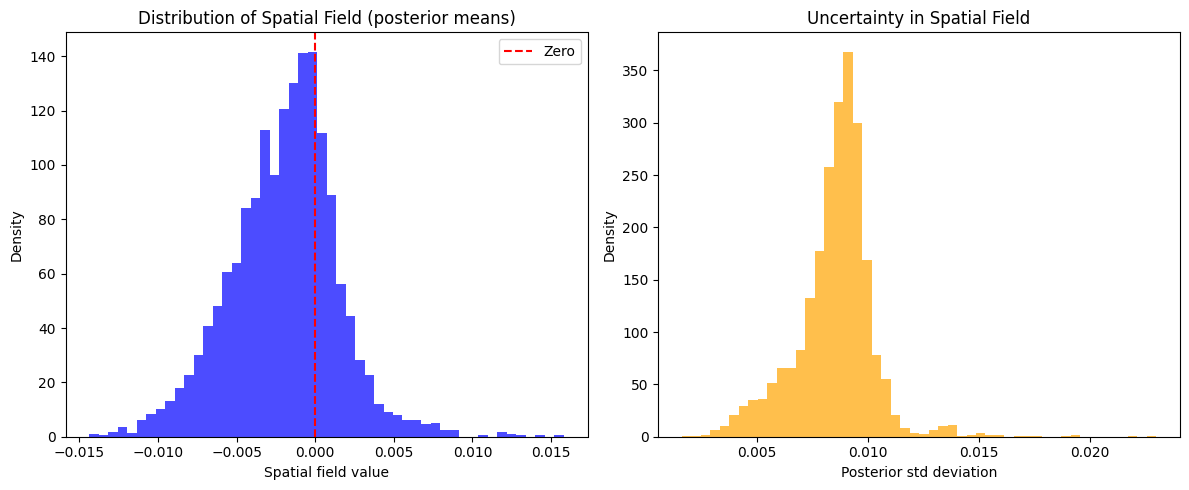

In [34]:
# Extract posterior mean of spatial field
w_cols = [col for col in draws.columns if col.startswith('w[')]
w_samples = draws[w_cols].values
w_mean = w_samples.mean(axis=0)
w_std = w_samples.std(axis=0)

print(f"Spatial field statistics:")
print(f"  Number of vertices: {len(w_mean)}")
print(f"  Mean value: {w_mean.mean():.3f}")
print(f"  Std of means: {w_mean.std():.3f}")
print(f"  Range: [{w_mean.min():.3f}, {w_mean.max():.3f}]")

# Plot distribution of spatial field values
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution of posterior means
axes[0].hist(w_mean, bins=50, density=True, alpha=0.7, color='blue')
axes[0].axvline(0, color='red', linestyle='--', label='Zero')
axes[0].set_xlabel('Spatial field value')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Spatial Field (posterior means)')
axes[0].legend()

# Uncertainty in spatial field
axes[1].hist(w_std, bins=50, density=True, alpha=0.7, color='orange')
axes[1].set_xlabel('Posterior std deviation')
axes[1].set_ylabel('Density')
axes[1].set_title('Uncertainty in Spatial Field')

plt.tight_layout()
plt.show()

### Geographic Visualization of Spatial Patterns

Visualize the spatial field and residuals overlaid on the geographic locations.

In [35]:
# Load required libraries for geographic visualization
import geopandas as gpd
from plotnine import *
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Load original coordinate data
pm25_data = pd.read_csv('north_america_pm25.csv')

# We need to reload the preprocessed coordinate data
import sys
sys.path.insert(0, '..')
from geo_spde.coords import preprocess_coords

# Get coordinates in original lon/lat
lon_lat_coords = pm25_data[['Longitude', 'Latitude']].to_numpy()

# Process to get the same cleaned coordinates used in modeling
clean_coords, indices, proj_info = preprocess_coords(
    lon_lat_coords,
    remove_duplicates=True
)

# Get the cleaned data
pm25_clean = pm25_data.iloc[indices].copy()
lon_lat_clean = lon_lat_coords[indices]

Detected geographic coordinates (lon/lat)
Auto-detected scale: multi_region (diameter ≈ 10765.0 km)
Projected to: Albers Equal-Area Conic
Coordinate preprocessing complete: 1339 -> 1339 points
Projected extent: 9102257 × 6147723 meters


In [36]:
# Compute spatial field at observation locations using A matrix
# Extract A matrix structure from stan_data
A_w = np.array(stan_data['A_w'])
A_v = np.array(stan_data['A_v']) - 1  # Convert to 0-indexed
A_u = np.array(stan_data['A_u']) - 1  # Convert to 0-indexed

# Function to multiply sparse CSR matrix with vector
def csr_matvec(w_vals, v_indices, u_pointers, x):
    """Multiply CSR matrix with vector"""
    n_rows = len(u_pointers) - 1
    result = np.zeros(n_rows)
    
    for i in range(n_rows):
        for j in range(u_pointers[i], u_pointers[i+1]):
            result[i] += w_vals[j] * x[v_indices[j]]
    
    return result

# Compute spatial field at observation locations
w_at_obs = csr_matvec(A_w, A_v, A_u, w_mean)

# Compute model predictions and residuals
alpha_mean = draws['alpha'].mean()

# Fixed effects prediction (without spatial field)
fixed_pred = alpha_mean

# Full model prediction at observations
y_pred_full = fixed_pred + w_at_obs

# Residuals
residuals = y_obs - y_pred_full

print(f"Spatial field contribution at observations:")
print(f"  Mean: {w_at_obs.mean():.3f}")
print(f"  Std: {w_at_obs.std():.3f}")
print(f"  Range: [{w_at_obs.min():.3f}, {w_at_obs.max():.3f}]")

Spatial field contribution at observations:
  Mean: -0.321
  Std: 1.100
  Range: [-7.508, 13.273]


In [37]:
# Load USA map from naturalearth
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
north_america_map = world[world['ISO_A3'].isin(['CAN', 'USA', 'MEX'])]

# Project map to same coordinate system as our data
north_america_proj = north_america_map.to_crs(proj_info['proj4_string'])

# Create dataframe with all visualization data
viz_df = pd.DataFrame({
    'Longitude': lon_lat_clean[:, 0],
    'Latitude': lon_lat_clean[:, 1],
    'x_proj': clean_coords[:, 0],
    'y_proj': clean_coords[:, 1],
    'PM25_observed': y_obs,
    'PM25_predicted': y_pred_full,
    'spatial_field': w_at_obs,
    'residual': residuals,
})

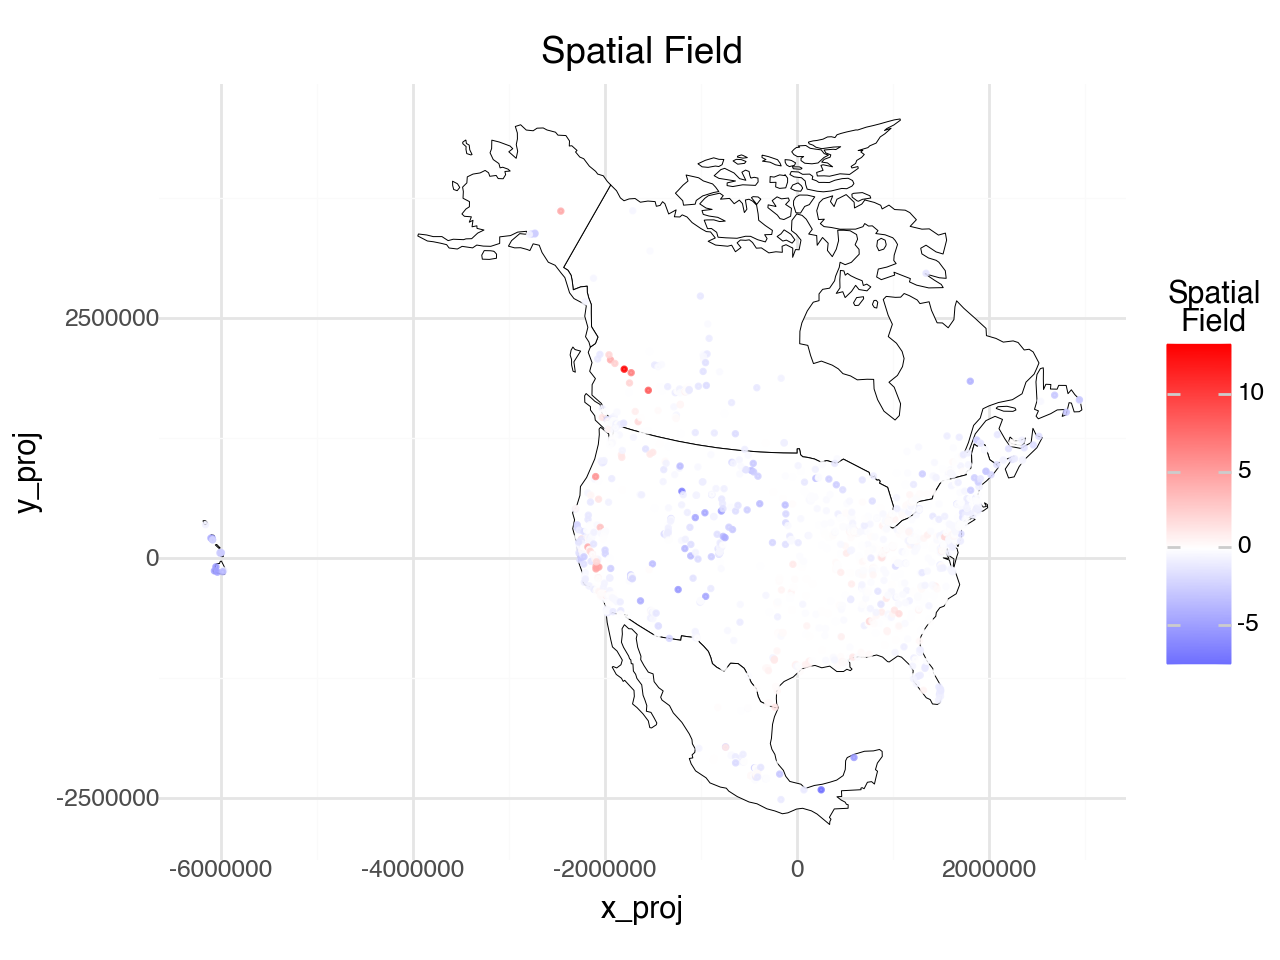

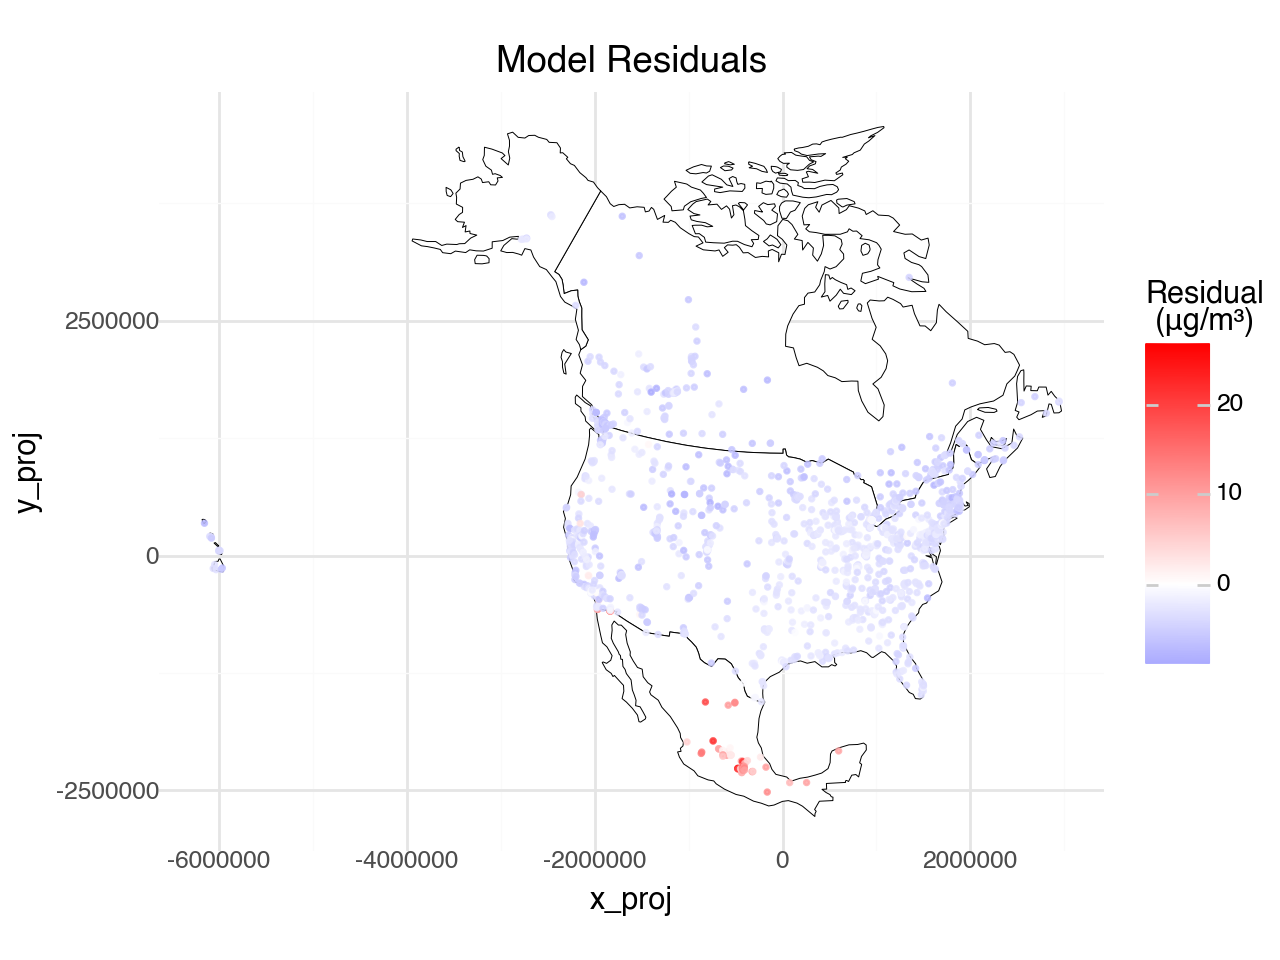

In [38]:
# Additional visualization: Urban vs Rural effects
# First, create a proper categorical variable for urban/rural

p_map = (ggplot() +
    geom_map(north_america_proj, fill='white', color='black', size=0.2) +
    geom_point(data=viz_df,
               mapping=aes(x='x_proj', y='y_proj', 
                          color='spatial_field'),
               size=0.5, alpha=0.8) +
    scale_color_gradient2(low='blue', mid='white', high='red',
                          midpoint=0, name='Spatial\nField') +
    theme_minimal() +
    labs(title="Spatial Field") +
    coord_fixed())
display(p_map)

# Alternative: Show residuals by urban/rural
p_map_residuals = (ggplot() +
    geom_map(north_america_proj, fill='white', color='black', size=0.2) +
    geom_point(data=viz_df,
               mapping=aes(x='x_proj', y='y_proj', 
                          color='residual'),
               size=0.5, alpha=0.8) +
    scale_color_gradient2(low='blue', mid='white', high='red',
                          midpoint=0, name='Residual\n(μg/m³)') +
    theme_minimal() +
    labs(title="Model Residuals") +
    coord_fixed())

display(p_map_residuals)

### Summary

This notebook successfully:
1. Compiled the SPDE Stan model
2. Loaded preprocessed data from the FEM pipeline
3. Ran MCMC sampling with diagnostics
4. Visualized parameter distributions and convergence
5. Performed posterior predictive checks
6. Extracted and analyzed the spatial field

The model captures spatial correlation through the latent field `w`, providing better predictions than a non-spatial model would.